<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><div align="center">This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.</div>

----

# Preamble

Normally, we would need to initialize a [`SparkContext`](https://jaceklaskowski.gitbooks.io/mastering-apache-spark/spark-SparkContext.html#creating-instance) in order to perform initialization.  However, this is automatically done in this IPython installation, so we skip this part. (Only *one* `SparkContext` object can be alive at the same time.)

In [1]:
#sc = SparkContext(appName="Python")

Evaluate the following cell to confirm that the PySpark kernel has been started correctly and that a `SparkContext` is already available in variable `sc`:

In [2]:
sc

<SparkContext master=yarn appName=pyspark-shell>

----

## Exercise 3.A

Read the documentation for the [`spark.read.csv`]() function and find out how to modify the above function call so that: *(1)* column names are taken from the first row (header) of the file; *(2)* column types are inferred from the data type.

In [9]:
df = spark.read.csv("hdfs:///wordbank.csv.gz", header=True, inferSchema=True)

If your way of reading data was right, evaluating the following cells should present a table with columnes `_c0`, `data_id`, `num_item_id`, `age`, ..., `produces`, `word`, of which the `_c0`, `data_id`, and `num_item_id` are integers, `produces` is boolean, and the rest are string-valued:

In [10]:
# look for headers and first values
df.show(5)

+---+-------+-----------+---+--------+------+-----------+---------+--------+---------+
|_c0|data_id|num_item_id|age|language|   sex|birth_order|ethnicity|produces|     word|
+---+-------+-----------+---+--------+------+-----------+---------+--------+---------+
|  0|  51699|         13| 27| English|Female|     Fourth| Hispanic|   false|alligator|
|  1|  51699|         14| 27| English|Female|     Fourth| Hispanic|    true|   animal|
|  2|  51699|         15| 27| English|Female|     Fourth| Hispanic|   false|      ant|
|  3|  51699|         16| 27| English|Female|     Fourth| Hispanic|    true|     bear|
|  4|  51699|         17| 27| English|Female|     Fourth| Hispanic|   false|      bee|
+---+-------+-----------+---+--------+------+-----------+---------+--------+---------+
only showing top 5 rows



In [11]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- data_id: integer (nullable = true)
 |-- num_item_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- birth_order: string (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- produces: boolean (nullable = true)
 |-- word: string (nullable = true)



----

----

## Exercise 3.B

Modify the "word count" code of *Exercise 2.D* to return the word counts as a DataFrame instead of an RDD.

In [ ]:
# assuming we have a `wordcount()` function already defined

def wordcount2(source):
    from pyspark.sql.types import StructType, StructField, StringType, IntegerType
    rdd = wordcount(source)
    df = spark.createDataFrame(rdd, schema=StructType([
        StructField('word', StringType()),
        StructField('count', IntegerType()),
    ]))
    return df

----

----

## Exercise 3.C

Count the number of rows where column `'sex'` has the value `'Male'` and the count of rows where column `sex` has value `'Female'`.  Does this equal the total number of rows in the dataset?  If not, what other values for `sex` are there?

In [22]:
df.where(df.sex == 'Male').count()

89053

In [23]:
df.where(df.sex == 'Female').count()

83979

In [24]:
df.count() == df.where(df.sex == 'Male').count() + df.where(df.sex == 'Female').count()

False

In [25]:
df.select('sex').distinct().show()

+------+
|   sex|
+------+
|  null|
|Female|
|  Male|
+------+



----

## Exercise 3.D

Compute the total number of words uttered relative to age, for: all children, male children, female children.

In [29]:
# 1. aggregate
gd = df.groupBy('age')

# 2. sum over 'produces' column
df_ = gd.agg(F.sum(df.produces.cast('integer')).alias('nr_words'))


# 3. show
df_.show(5)

+---+--------+
|age|nr_words|
+---+--------+
| 28|   28143|
| 27|    5740|
| 26|    5011|
| 22|    4133|
| 16|    6032|
+---+--------+
only showing top 5 rows



In [30]:
# 1. aggregate
gd2 = df.groupBy(['age', 'sex'])

# 2. sum over 'produces' column
df_mf = gd2.agg(F.sum(df.produces.cast('integer')).alias('nr_words'))


# 3. show
df_mf.where(df_mf.sex == 'Male').show(5)

+---+----+--------+
|age| sex|nr_words|
+---+----+--------+
| 26|Male|    1773|
| 25|Male|    2571|
| 24|Male|    4843|
| 27|Male|    2032|
| 20|Male|    1296|
+---+----+--------+
only showing top 5 rows



----

## Exercise 3.E

Make a bar plot of the number of words produced by age.

(*Hint:* Seaborn provides an easy-to-use `.barplot` function)

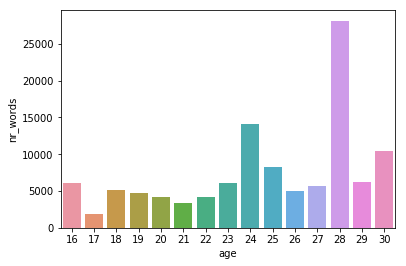

In [34]:
import seaborn as sns

sns.barplot(x="age", y="nr_words", data=df_.toPandas(), label="Nr. of distinct animal names")

A lengthier solution is to pull the data out using `df_.collect()` then separate the `x` and `y` arrays for the plot:

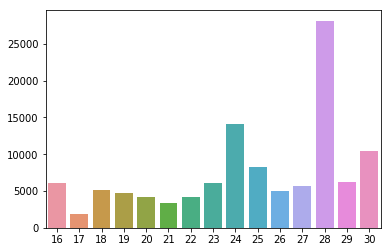

In [33]:
rows= df_.collect()

xs = [row[0] for row in rows]
ys = [row[1] for row in rows]

sns.barplot(x=xs, y=ys)